# Contexto

El proyecto trata sobre **Uber Inc.**, la compañía de taxis más grande del mundo. En este trabajo, nuestro objetivo es **predecir la tarifa de futuros viajes**.  

Uber brinda servicio a millones de clientes cada día, por lo que gestionar adecuadamente sus datos es clave para desarrollar nuevas estrategias de negocio y obtener mejores resultados.  

### Variables del conjunto de datos  

**Variables explicativas:**  
- **key**: identificador único de cada viaje.
- **date**: fecha y hora.  
- **pickup_datetime**: fecha y hora en que se inició el viaje.  
- **passenger_count**: cantidad de pasajeros en el vehículo (dato ingresado por el conductor).  
- **pickup_longitude**: longitud del punto de inicio del viaje.  
- **pickup_latitude**: latitud del punto de inicio del viaje.  
- **dropoff_longitude**: longitud del punto de destino.  
- **dropoff_latitude**: latitud del punto de destino.  

**Variable objetivo (target):**  
- **fare_amount**: costo del viaje en dólares.  

# Librerías

In [20]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error

import holidays
from haversine import haversine
from pandas import DataFrame

from geopy.distance import geodesic


# Carga del dataset



In [21]:
# Carga de datos del dataset en dataframe
file_path= 'uber_fares.csv'

df = pd.read_csv(file_path)


# Análisis exploratorio de datos

## Análisis descriptivo

In [22]:
df.head()

,key,date,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [23]:
# Columnas, ¿cuáles son variables numéricas y cuales variables categóricas?
df.columns

Index(['key', 'date', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

-Variables numéricas: fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, droptoff_latitude, passenger_count.

-Variables categóricas: key, date, pickup_datetime, passenger_count.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                200000 non-null  int64  
 1   date               200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [25]:
# Valores nulos
df.isna().sum()

key                  0
date                 0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

## Análisis de datos atípicos

Para comenzar, quitamos los renglones en donde los valores de la columna objetivo sea nula o menor a 0

In [26]:
def check_nan_percentage(df):
    nan_cant = df.isna().sum()
    nan_porcentaje = (nan_cant / len(df)) * 100

    nan_info = pd.DataFrame({
        'Cantidad': nan_cant,
        'Porcentaje': nan_porcentaje
    })

    nan_info['Porcentaje'] = nan_info['Porcentaje'].apply(lambda x: f"{x:.2f}%")

    print(nan_info)

check_nan_percentage(df)

                   Cantidad Porcentaje
key                       0      0.00%
date                      0      0.00%
fare_amount               0      0.00%
pickup_datetime           0      0.00%
pickup_longitude          0      0.00%
pickup_latitude           0      0.00%
dropoff_longitude         1      0.00%
dropoff_latitude          1      0.00%
passenger_count           0      0.00%


In [27]:
df = df[df['fare_amount']>0].copy()
fare_99 = df['fare_amount'].quantile(0.99)
df = df[df['fare_amount'] <= fare_99].copy()

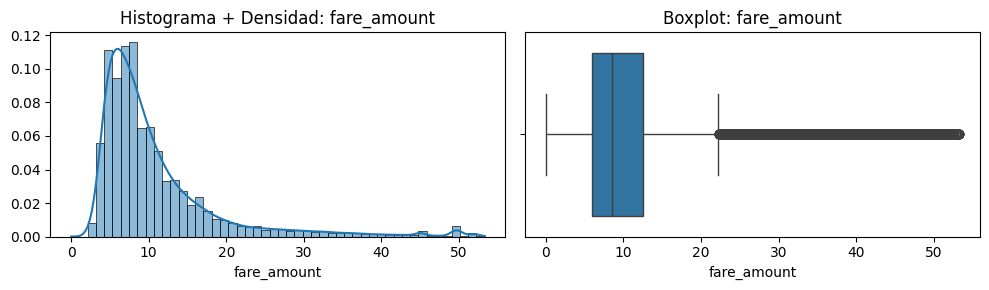

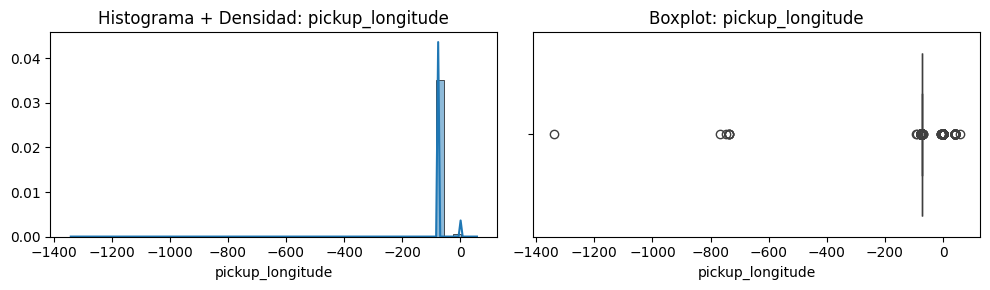

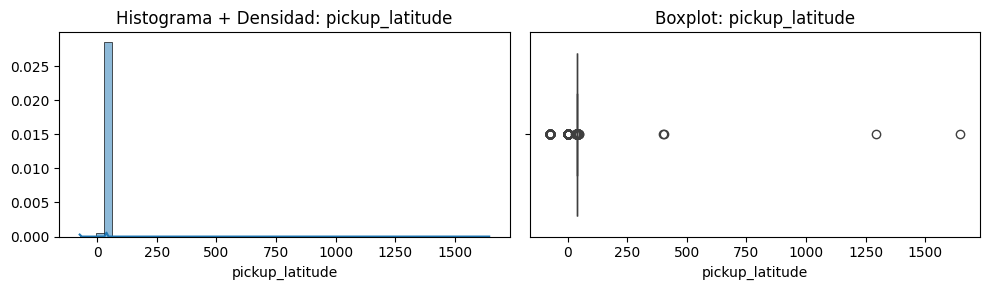

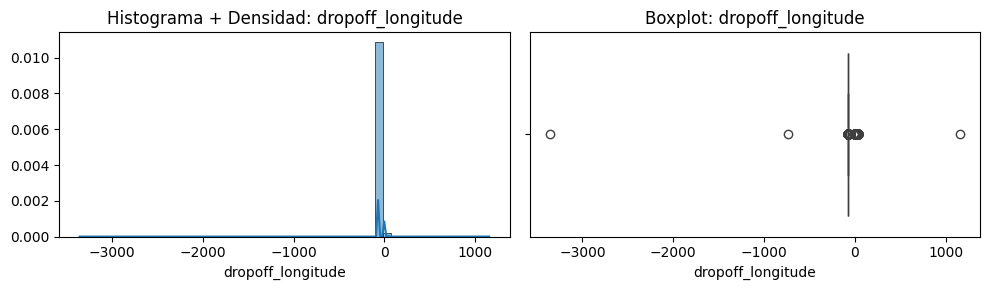

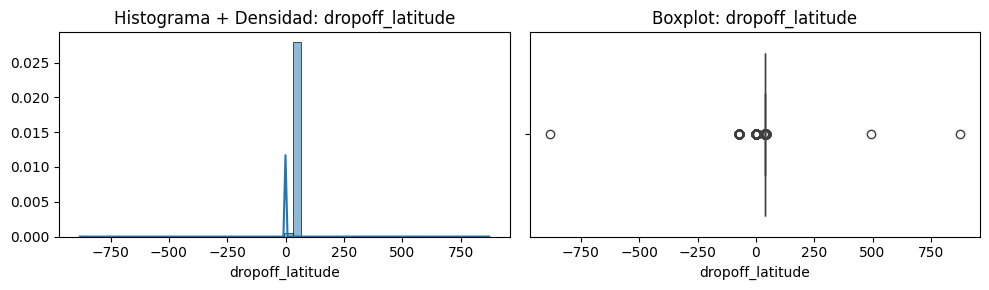

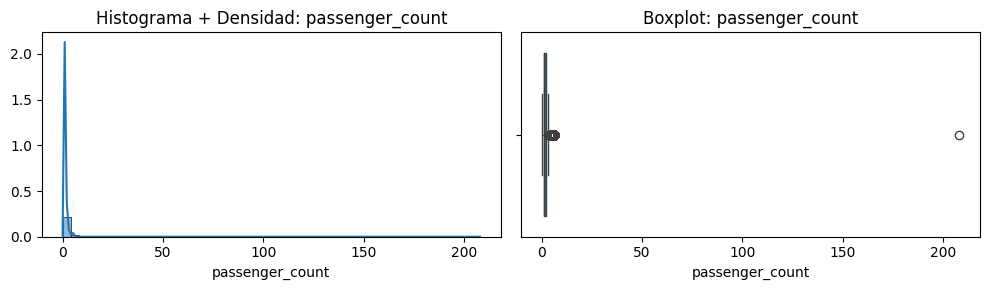

In [28]:
# Histogramas + densidad y boxplots
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('key')

def densityHistBoxPlot(df: DataFrame, cols: list):
    for c in cols:
        plt.figure(figsize=(10,3))
        
        # Histograma + densidad
        plt.subplot(1,2,1)
        sns.histplot(df[c].dropna(), bins=50, kde=True, stat="density")
        plt.title(f"Histograma + Densidad: {c}")
        plt.ylabel("")
        
        # Boxplot
        plt.subplot(1,2,2)
        sns.boxplot(x=df[c].dropna())
        plt.title(f"Boxplot: {c}")
        
        plt.tight_layout()
        plt.show()

densityHistBoxPlot(df, num_cols)

En las gráficas podemos encontrar que hay valores atípicos sin sentido, como un Uber con más de 200 pasajeros o latitudes y longitudes que exceden los límites. De la gráfica de la densidad de la columna objetivo `fare_amount`, vemos que hay una tendencia a viajes poco costosos. Esto puede hacer que el modelo no sea representativo para viajes mayores a 15 o 20 dólares. Para analizar la densidad de distribución de las demás variables (latitud, longitud y cantidad de pasajeros), sería recomendable remover los valores sin sentido y volver a realizar la gráfica.

## Codificación de variables categóricas

Divimos los casos de la cuenta de pasajeros según lo considerábamos un delivery, un servicio normal o uno premium, utilizando variables dummies para la misma

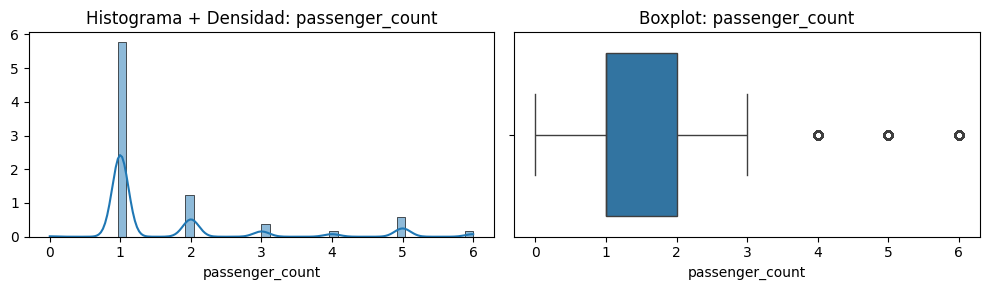

In [29]:
# Cantidad de pasajeros/as
df.loc[(df['passenger_count'] < 0), 'passenger_count'] = 0
df.loc[(df['passenger_count'] > 6), 'passenger_count'] = 6

densityHistBoxPlot(df, ['passenger_count'])


A partir de la distribución de la cantidad de pasajeros observamos en el dataset una tendencia por viajes realizados por un solo pasajero, haciendo a nuestro modelo más confiable para estos casos, descuidando los otros. Incluso, se puede considerar como outliers los valores 4, 5 y 6 de la cuenta de pasajeros.

In [30]:
# Crear categorías para cantidad de pasajeros
def categorize_passengers(count):
    if count == 0:
        return 'delivery'
    elif 1 <= count <= 4:
        return 'normal'
    elif 5 <= count <= 6:
        return 'xl'

df['passenger_category'] = df['passenger_count'].apply(categorize_passengers)

# Crear dummies para las categorías
passenger_dummies = pd.get_dummies(df['passenger_category'], prefix='passenger', dtype=int, drop_first=True)
df = pd.concat([df, passenger_dummies], axis=1)

# Dropear columnas que no serán utilizadas
df.drop(columns=['passenger_category','passenger_count'], inplace=True)

Se transforma la columna de fechas en componentes útiles (hora, día, semana, mes), generando variables binarias para franjas horarias y estaciones. Además, se codifican días de semana y semanas en el año con funciones seno/coseno y se marca fines de semana/feriados. Finalmente, se eliminan columnas intermedias innecesarias.

In [31]:
# Separar datetime en date y time
df["dateTime"] = pd.to_datetime(df["pickup_datetime"]) # sin errors, ya que checkeamos que no hay valores nulos
df["dateTime"] = df["dateTime"].dt.tz_convert("America/New_York") # Esto cubre el horario de verano

df["time"] = df["dateTime"].dt.hour
df["date"] = df["dateTime"].dt.date

# 1 a 7 ==> madrugada ==> V = 1  ==> CODIFICACIÓN BINARIA ==> 0 | 0
# 7 a 11 ==> mañana ==> V = 2 ==> CODIFICACIÓN BINARIA ==> 0 | 1
# 11 a 19 ==> tarde ==> V = 3 ==> CODIFICACIÓN BINARIA ==> 1 | 1
# 19 a 1 ==> noche ==> V = 4 ==> CODIFICACIÓN BINARIA ==> 1 | 0

df["bin_time_1"] = 0
df["bin_time_2"] = 0

df.loc[(df["time"] >= 7) & (df["time"] < 11), ["bin_time_1", "bin_time_2"]] = [0, 1]
df.loc[(df["time"] >= 11) & (df["time"] < 19), ["bin_time_1", "bin_time_2"]] = [1, 1]
df.loc[(df["time"] >= 19) | (df["time"] < 1), ["bin_time_1", "bin_time_2"]] = [1, 0]

df["date"] = pd.to_datetime(df["date"])

df["weekday_num"] = df["date"].dt.dayofweek + 1

# k = (2*math.pi)/7 # 7 por los días de la semana

# df["sen_weekday_num"] = np.sin(k*df["weekday_num"])
# df["cos_weekday_num"] = np.cos(k*df["weekday_num"])

# k_week= 2*np.pi/52

# df["week"] = df["date"].dt.isocalendar().week

# df["sen_week_num"] = np.sin(k_week*df["week"])
# df["cos_week_num"] = np.cos(k_week*df["week"])

# Traer feriados para validar si es fin de semana o feriado
us_holidays = holidays.US(state="NY")

df["weekend_or_holiday"] = ((df["weekday_num"] >= 6) | (df["date"].dt.date.isin(us_holidays))).astype(int)

# INVIERNO: de diciembre a febrero ==> CODIFICACIÓN BINARIA ==> 0 | 0
# PRIMAVERA: de marzo a mayo ==> CODIFICACIÓN BINARIA ==> 0 | 1
# VERANO: de junio a agosto ==> CODIFICACIÓN BINARIA ==> 1 | 1
# OTOÑO: de septiembre a noviembre ==> CODIFICACIÓN BINARIA ==> 1 | 0

# df['month'] = df['date'].dt.month

# df["bin_month_1"] = 0
# df["bin_month_2"] = 0

# df.loc[(df['month'] >= 3) & (df['month'] < 6), ["bin_month_1", "bin_month_2"]] = [0, 1]
# df.loc[(df['month'] >= 6) & (df['month'] < 9), ["bin_month_1", "bin_month_2"]] = [1, 1]
# df.loc[(df['month'] >= 9) & (df['month'] < 12), ["bin_month_1", "bin_month_2"]] = [1, 0]
# df.loc[(df['month'] == 12) | (df['month'] < 3), ["bin_month_1", "bin_month_2"]] = [0, 0]

# df.drop(columns=['dateTime', 'date', 'time', 'weekday_num','key', 'week', 'month', 'pickup_datetime'], inplace=True)
df.drop(columns=['dateTime', 'date', 'time', 'weekday_num','key', 'pickup_datetime'], inplace=True)


## Región geográfica de estudio - Imputación de la longitud y latitud

Según el NYC Department of City Planning, los límites de la ciudad se encuentran en:
- West −74.257159° 
- East −73.699215° 
- North 40.915568° 
- South 40.496010°

Nosotros redondeamos un poco estos valores para poder delimitar correctamente la ciudad.

- longitud ==> este/oeste
- latitud ==> norte/sur

In [32]:
# Setear coordenadas inválidas a NaN
df.loc[df["pickup_latitude"] > 40.92, ["pickup_latitude"]] = np.nan
df.loc[df["pickup_latitude"] < 40.5, ["pickup_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] > 40.92, ["dropoff_latitude"]] = np.nan
df.loc[df["dropoff_latitude"] < 40.5, ["dropoff_latitude"]] = np.nan

df.loc[df["pickup_longitude"] > -73.6, ["pickup_longitude"]] = np.nan
df.loc[df["pickup_longitude"] < -74.25, ["pickup_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] > -73.6, ["dropoff_longitude"]] = np.nan
df.loc[df["dropoff_longitude"] < -74.25, ["dropoff_longitude"]] = np.nan


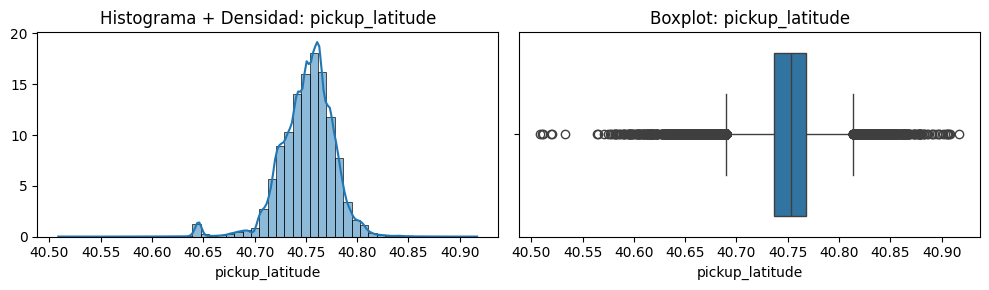

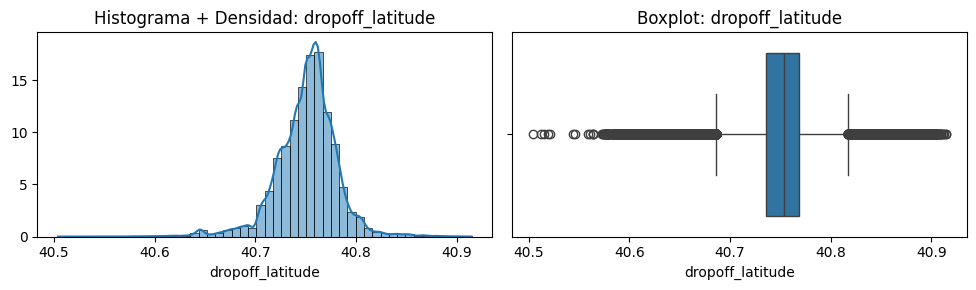

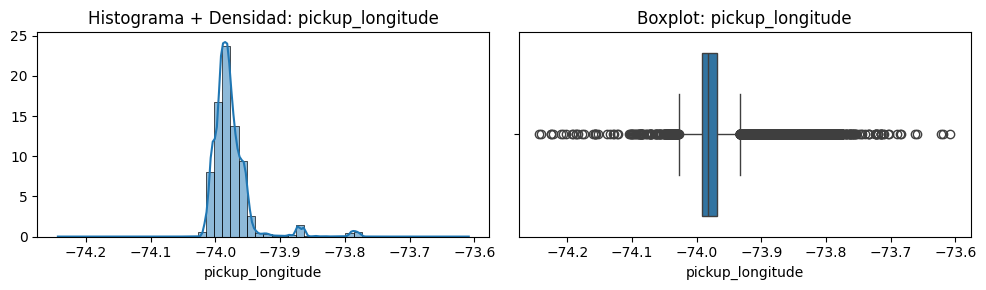

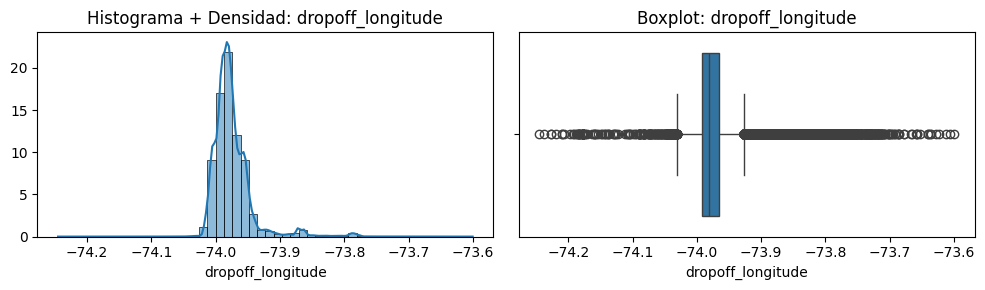

In [35]:
densityHistBoxPlot(df, ["pickup_latitude","dropoff_latitude","pickup_longitude","dropoff_longitude",])

Una vez eliminados los valores sin sentido para los latitudes y longitudes, podemos observar que existen outliers para las 4 columnas, con una campana bien marcada para valores de latitud entre $40.7$ y $40.8$, y entre $-74.0$ y $-73.9$ para la longitud. Fuera de estos valores, se observan muchos puntos dispersos para los rangos tenidos en consideración que, si observamos los boxplots a la derecha de cada histograma, son outliers para mi problema.  

In [13]:
def manhattan_distance(lat1, lon1, lat2, lon2):
    north_south = geodesic((lat1, lon1), (lat2, lon1)).kilometers
    east_west = geodesic((lat1, lon1), (lat1, lon2)).kilometers
    return north_south + east_west

def calculate_distance_safe(row):
    """Calcula distancia solo si las 4 coordenadas no son nulas"""
    if pd.notna(row['pickup_latitude']) and pd.notna(row['pickup_longitude']) and \
        pd.notna(row['dropoff_latitude']) and pd.notna(row['dropoff_longitude']):
        return manhattan_distance(
            row['pickup_latitude'], row['pickup_longitude'],
            row['dropoff_latitude'], row['dropoff_longitude']
        )
    else:
        return np.nan

In [14]:
df['distance_km'] = df.apply(calculate_distance_safe, axis=1)
df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1)

Realizamos un filtro para eliminar los valores donde el punto de partida y salida es el mismo (es decir, la distancia recorrida es igual a 0), escalamos las variables y luego imputamos los valores faltantes o nulos con KNN. Finalmente, calculamos la distancia con la métrica de Manhattan.

In [15]:
df.loc[df["distance_km"] < 0.01, "distance_km"] = np.nan


Aquí se eliminaron los puntos en donde la distancia recorrida es cercana a 0 (se considera este caso uno de "ida y vuelta").

In [16]:
df.columns

Index(['fare_amount', 'passenger_normal', 'passenger_xl', 'bin_time_1',
       'bin_time_2', 'weekend_or_holiday', 'distance_km'],
      dtype='object')

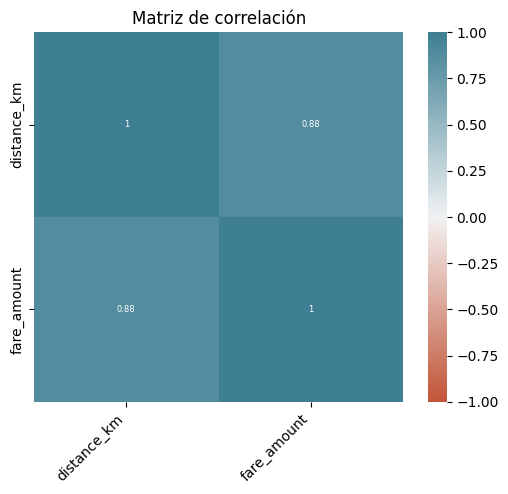

In [19]:
ax = sns.heatmap(
    df[['distance_km','fare_amount']].corr(),
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.title('Matriz de correlación')
plt.show()

Vemos que la matriz muestra un coeficiente de correlación de $0.88$ entre la distancia (medida en km) y el valor del precio del Uber, mostrando una dependencia lineal fuerte entre ambas (debido a su valor cercano a $1$).

## Escalado y spliteo

In [211]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# KNN para imputar distancias
imputer = KNNImputer(n_neighbors=10, weights='distance')
train_df[['distance_km']] = imputer.fit_transform(train_df[['distance_km']])
test_df[['distance_km']] = imputer.transform(test_df[['distance_km']])

# Separar X e y ANTES de escalar
x_train = train_df.drop(['fare_amount'], axis=1).copy()
y_train = train_df[['fare_amount']].copy()
x_test = test_df.drop(['fare_amount'], axis=1).copy()
y_test = test_df[['fare_amount']].copy()

# Escalar SOLO distance_km
scaler = RobustScaler()
x_train[['distance_km']] = scaler.fit_transform(x_train[['distance_km']])
x_test[['distance_km']] = scaler.transform(x_test[['distance_km']])

Una vez que obtuvimos la posición del inicio y el final del recorrido, obtenemos la distancia en km.

In [212]:
x_train = train_df.drop(['fare_amount'], axis = 1).copy()
y_train = train_df[['fare_amount']].copy()

x_test = test_df.drop(['fare_amount'], axis = 1).copy()
y_test = test_df[['fare_amount']].copy()

In [213]:
x_train.columns

Index(['passenger_normal', 'passenger_xl', 'bin_time_1', 'bin_time_2',
       'weekend_or_holiday', 'distance_km'],
      dtype='object')

Una vez obtenidas las variables que se van a utilizar en la regresión lineal, realizamos la matriz de correlación de los datos, junto con el histograma y boxplot de la distancia en km.

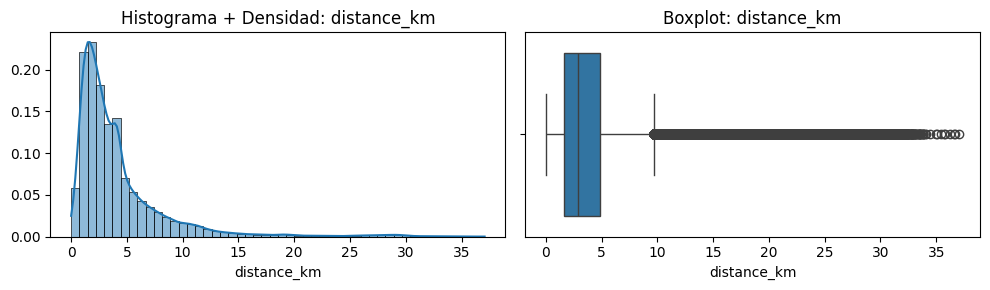

In [214]:
densityHistBoxPlot(train_df, ["distance_km"])


## Regresión lineal

In [215]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_test)

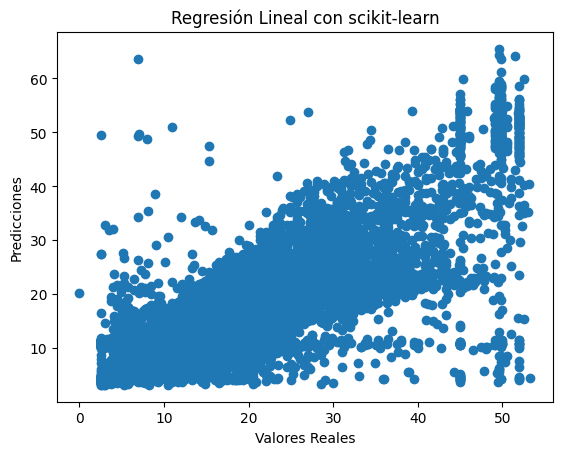

In [216]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Regresión Lineal con scikit-learn")
plt.show()

In [217]:
# Métricas del modelo
mse_selfeat = mean_squared_error(y_test, y_pred)
rmse_selfeat = np.sqrt(mse_selfeat)
mae_selfeat = mean_absolute_error(y_test, y_pred)
mape_selfeat = mean_absolute_percentage_error(y_test, y_pred)
r2_selfeat = r2_score(y_test, y_pred)
score_selfeat = linear_model.score(x_test, y_test)
score_selfeat_train = linear_model.score(x_train, y_train)

print(f"Puntaje train: {score_selfeat_train}")
print(f"Puntaje test: {score_selfeat}")
print(f'Error cuadrático medio (MSE) con features seleccionadas: {mse_selfeat:.2f}')
print(f'Raíz del error cuadrático medio (RMSE) con features seleccionadas: {rmse_selfeat:.2f}')
print(f'Error absoluto medio (MAE) con features seleccionadas: {mae_selfeat:.2f}')
print(f'Error absoluto medio porcentual (MAPE) con features seleccionadas: {mape_selfeat:.2f}')
print(f'Coeficiente de determinación (R^2) con features seleccionadas: {r2_selfeat:.2f}\n')

Puntaje train: 0.7305991176078133
Puntaje test: 0.7320126463655188
Error cuadrático medio (MSE) con features seleccionadas: 17.83
Raíz del error cuadrático medio (RMSE) con features seleccionadas: 4.22
Error absoluto medio (MAE) con features seleccionadas: 2.47
Error absoluto medio porcentual (MAPE) con features seleccionadas: 0.30
Coeficiente de determinación (R^2) con features seleccionadas: 0.73



In [218]:
def resPlot(modelo, nombre_modelo, x_test, y_test):
    pred = modelo.predict(x_test)
    
    if hasattr(y_test, 'values'):
        y_test_array = y_test.values.ravel()
    else:
        y_test_array = y_test.ravel()
    
    pred = pred.ravel()
    
    plt.figure(figsize=(5,3))
    plt.scatter(pred, y_test_array - pred, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.title(f"Residuos - {nombre_modelo}")
    plt.xlabel("Predicho")
    plt.ylabel("Residuo")
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(8,4))
    fig.suptitle(f'Residuos porcentuales - {nombre_modelo}')
    plt.xlabel('Valores de test')
    plt.ylabel('Residuos (%)')
    
    percentage_residuals = np.where(y_test_array != 0, 
                                   100 * (y_test_array - pred) / y_test_array, 0)
    plt.scatter(y_test_array, percentage_residuals, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.show()

    return

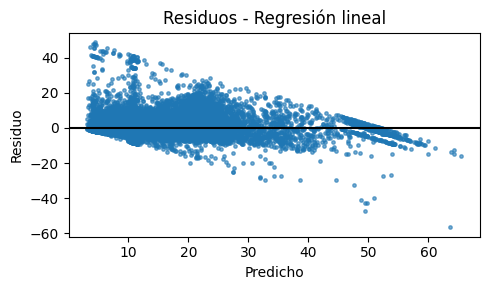

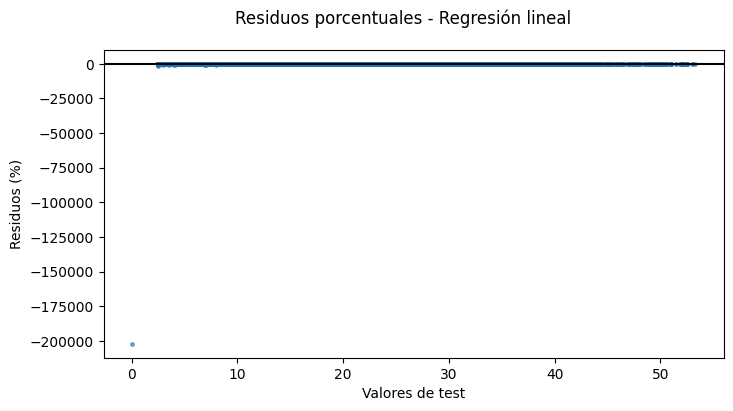

In [219]:
resPlot(linear_model, 'Regresión lineal', x_test, y_test)


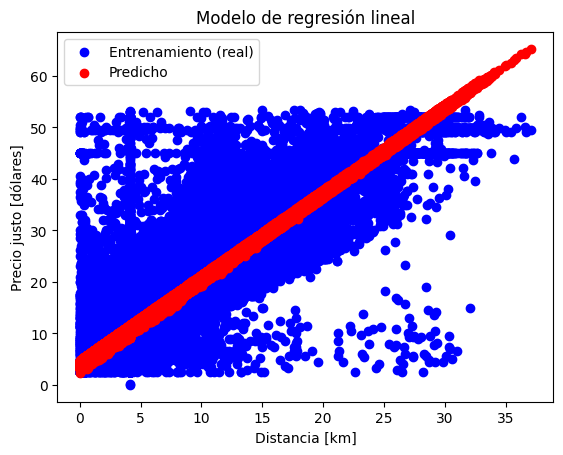

In [220]:
plt.scatter(x_train['distance_km'], y_train, color='blue',label='Entrenamiento (real)')
plt.scatter(x_train['distance_km'], linear_model.predict(x_train), color='red',label='Predicho')

plt.xlabel('Distancia [km]')
plt.ylabel('Precio justo [dólares]')
plt.legend()
plt.title('Modelo de regresión lineal')

plt.show()

## Descenso por gradiente

Implementamos tres variantes de descenso por gradiente desde cero:
- **Batch Gradient Descent (GD):** utiliza todo el dataset en cada iteración
- **Stochastic Gradient Descent (SGD):** actualiza pesos con un ejemplo a la vez
- **Mini-Batch Gradient Descent:** balancea eficiencia y estabilidad usando lotes pequeños

Los hiperparámetros (learning rate, epochs, batch size) fueron ajustados manualmente observando la convergencia del MSE y la mejora en R².

In [221]:
def gradient_descent(X_train, y_train, X_val, y_val, lr=0.01, epochs=100, tol=1e-6, patience=10):
    """
    shapes:
        X_train = nxm
        y_train = nx1
        X_val = pxm
        y_test = px1
        W = mx1
    """
    n = X_train.shape[0]
    m = X_train.shape[1]
    
    o = X_val.shape[0]

    # Poner columna de unos a las matrices X
    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_val = np.hstack((np.ones((o, 1)), X_val))
    

    # Inicializar pesos aleatorios
    W = np.random.randn(m+1).reshape(m+1, 1)

    train_errors = []  # Para almacenar el error de entrenamiento en cada época
    test_errors = []   # Para almacenar el error de prueba en cada época

    for _ in range(epochs):
        # Calcular predicción y error de entrenamiento
        prediction_train = np.matmul(X_train, W) 
        error_train = y_train - prediction_train  
        #print(error_train)
        train_mse = np.mean(error_train ** 2)
        train_errors.append(train_mse)

        # Calcular predicción y error de prueba
        prediction_test = np.matmul(X_val, W) 
        error_test = y_val - prediction_test 
        test_mse = np.mean(error_test ** 2)
        test_errors.append(test_mse)

        # Calcular el gradiente y actualizar pesos
        grad_sum = np.sum(error_train * X_train, axis=0)
        grad_mul = -2/n * grad_sum  # 1xm
        gradient = np.transpose(grad_mul).reshape(-1, 1)  # mx1

        W = W - (lr * gradient)

    # Graficar errores de entrenamiento y prueba
    # Definir una figura
    plt.figure(figsize=(12, 6))
    # Plotear errores de entrenamiento
    plt.plot(train_errors, label='Error de entrenamiento')
    # Plotear errores de prueba
    plt.plot(test_errors, label='Error de validación')
    # Poner labels en los ejes
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    # Activar la leyenda
    plt.legend()
    # Poner titulo
    plt.title('Error de entrenamiento y validación vs iteraciones (GD)')
    # Terminar y mostrar gráfico
    plt.show()

    return W

def stochastic_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, tol=1e-6, patience=10):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]

        for j in range(n):
            # Obtener una muestra aleatoria de un solo dato para hacer SGD
            x_sample = X_train[j]
            y_sample = y_train[j][0]

            prediction = np.matmul(x_sample, W)
            error = y_sample - prediction
            train_mse = error ** 2
            train_errors.append(train_mse)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

            gradient = -2 * error * x_sample.T.reshape(-1, 1)

            W = W - (lr * gradient)

            

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (SGD)')
    plt.show()

    return W

def mini_batch_gradient_descent(X_train, y_train, X_test, y_test, lr=0.01, epochs=100, batch_size=32, tol=1e-6, patience=10):
    n = X_train.shape[0]
    m = X_train.shape[1]

    X_train = np.hstack((np.ones((n, 1)), X_train))
    X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

    W = np.random.randn(m + 1).reshape(-1, 1)

    train_errors = []
    test_errors = []

    for i in range(epochs):
        
        # Permutación aleatoria de los datos
        permutation = np.random.permutation(n)
        X_train = X_train[permutation]
        y_train = y_train[permutation]


        for j in range(0, n, batch_size):
            # Obtener un lote (mini-batch) de datos
            x_batch = X_train[j:j+batch_size, :]
            y_batch = y_train[j:j+batch_size].reshape(-1, 1)

            prediction = np.matmul(x_batch, W)
            error = y_batch - prediction
            train_mse = np.mean(error ** 2)
            train_errors.append(train_mse)

            gradient = -2 * np.matmul(x_batch.T, error) / batch_size

            W = W - (lr * gradient)

            prediction_test = np.matmul(X_test, W)
            error_test = y_test - prediction_test
            test_mse = np.mean(error_test ** 2)
            test_errors.append(test_mse)

    plt.figure(figsize=(12, 6))
    plt.plot(train_errors, label='Error de entrenamiento')
    plt.plot(test_errors, label='Error de prueba')
    plt.xlabel('Iteración')
    plt.ylabel('Error cuadrático medio')
    plt.legend()
    plt.title('Error de entrenamiento y prueba vs iteraciones (Mini-Batch GD)')
    plt.show()

    return W



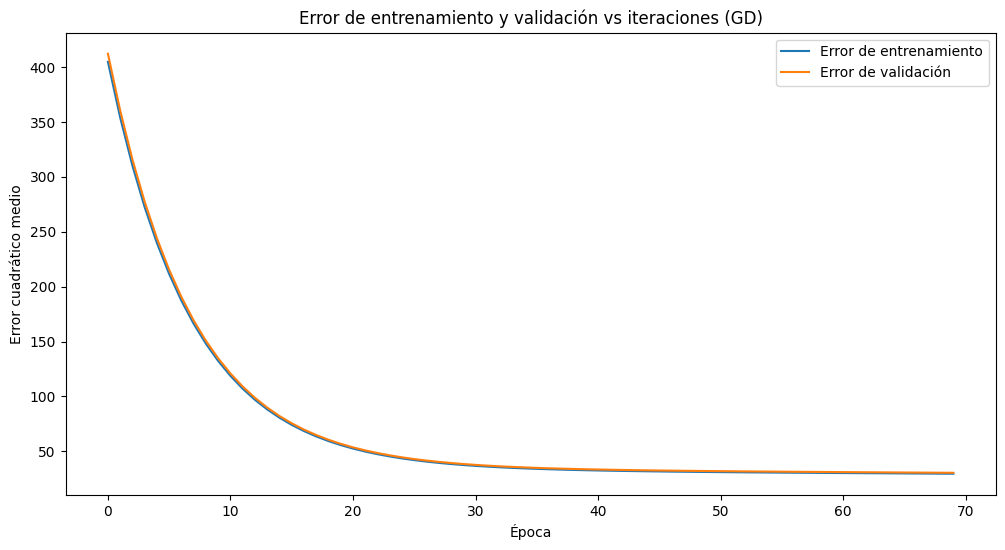

array([[-1.98637493],
       [ 2.26258552],
       [ 0.54406855],
       [-0.79371176],
       [-0.63408565],
       [-0.23484583],
       [ 2.2387185 ]])

In [222]:
gradient_descent(x_train.values,
    y_train.values,
    x_test.values,
    y_test.values,
    lr=0.001,
    epochs=70
)

/home/jere/tuia/aa1/aa1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


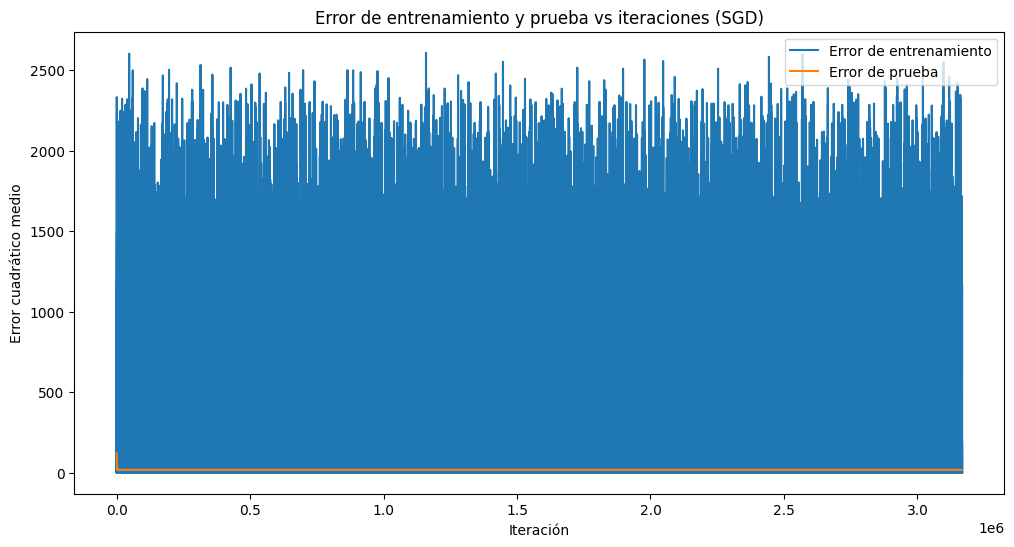

array([[ 2.64369782],
       [ 1.42156263],
       [ 1.5471943 ],
       [-0.63600934],
       [ 0.53381951],
       [-0.30216305],
       [ 1.60849059]])

In [223]:
stochastic_gradient_descent(x_train.values, y_train.values, x_test.values, y_test.values, lr=1e-5, epochs=20)


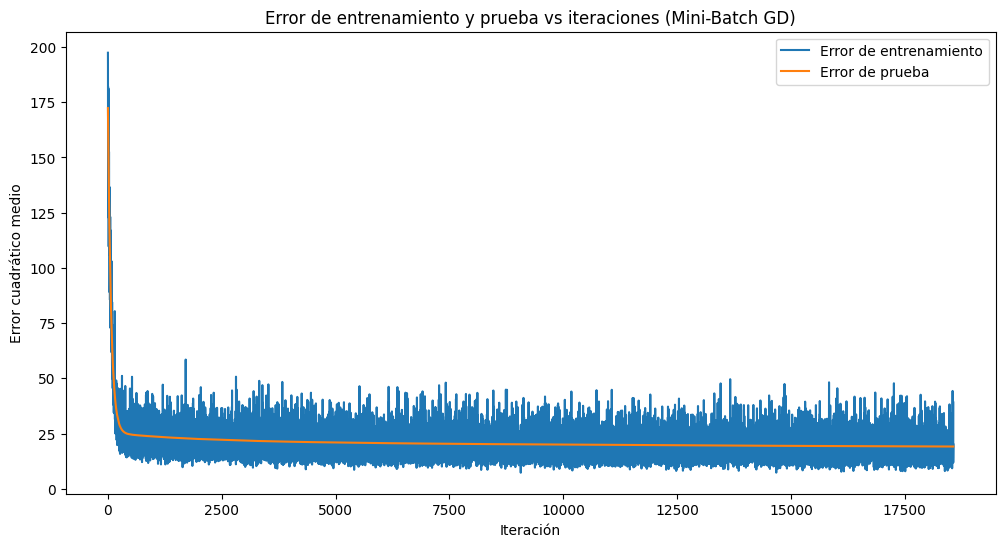

array([[ 1.55961053],
       [ 0.83411104],
       [-0.55543866],
       [-0.69480689],
       [ 2.19509258],
       [ 1.08504874],
       [ 1.71819342]])

In [233]:
mini_batch_gradient_descent(x_train.values, y_train.values, x_test.values, y_test.values, lr=1e-5, epochs=30, batch_size=256)


## Regularización

In [225]:
for i in range(-5, 3, 1):
    alpha_val = 10**i
    
    lasso = Lasso(alpha=alpha_val)
    ridge = Ridge(alpha=alpha_val)
    elasticnet = ElasticNet(alpha=alpha_val, l1_ratio=0.2)

    # Ajustar modelos a los datos
    linear_model.fit(x_train, y_train)
    lasso.fit(x_train, y_train)
    ridge.fit(x_train, y_train)
    elasticnet.fit(x_train, y_train)

    print(f"\n{'='*60}")
    print(f"ALPHA = 10^{i} = {alpha_val}")
    print(f"{'='*60}")

    # Predicciones para cada modelo
    y_pred_train_lr = linear_model.predict(x_train)
    y_pred_test_lr = linear_model.predict(x_test)
    
    y_pred_train_lasso = lasso.predict(x_train)
    y_pred_test_lasso = lasso.predict(x_test)
    
    y_pred_train_ridge = ridge.predict(x_train)
    y_pred_test_ridge = ridge.predict(x_test)
    
    y_pred_train_en = elasticnet.predict(x_train)
    y_pred_test_en = elasticnet.predict(x_test)

    # Métricas para Regresión Lineal
    print(f"\n--- Regresión Lineal ---")
    print("R² train:", r2_score(y_train, y_pred_train_lr))
    print("R² test :", r2_score(y_test, y_pred_test_lr))
    print("RMSE train:", np.sqrt(mean_squared_error(y_train, y_pred_train_lr)))
    print("RMSE test :", np.sqrt(mean_squared_error(y_test, y_pred_test_lr)))
    print("MAE train :", mean_absolute_error(y_train, y_pred_train_lr))
    print("MAE test :", mean_absolute_error(y_test, y_pred_test_lr))

    # Métricas para Lasso
    print(f"\n--- Lasso ---")
    print("R² train:", r2_score(y_train, y_pred_train_lasso))
    print("R² test :", r2_score(y_test, y_pred_test_lasso))
    print("RMSE train:", np.sqrt(mean_squared_error(y_train, y_pred_train_lasso)))
    print("RMSE test :", np.sqrt(mean_squared_error(y_test, y_pred_test_lasso)))
    print("MAE train :", mean_absolute_error(y_train, y_pred_train_lasso))
    print("MAE test :", mean_absolute_error(y_test, y_pred_test_lasso))
    print("Coeficientes:", lasso.coef_)

    # Métricas para Ridge
    print(f"\n--- Ridge ---")
    print("R² train:", r2_score(y_train, y_pred_train_ridge))
    print("R² test :", r2_score(y_test, y_pred_test_ridge))
    print("RMSE train:", np.sqrt(mean_squared_error(y_train, y_pred_train_ridge)))
    print("RMSE test :", np.sqrt(mean_squared_error(y_test, y_pred_test_ridge)))
    print("MAE train :", mean_absolute_error(y_train, y_pred_train_ridge))
    print("MAE test :", mean_absolute_error(y_test, y_pred_test_ridge))
    print("Coeficientes:", ridge.coef_)

    # Métricas para ElasticNet
    print(f"\n--- ElasticNet ---")
    print("R² train:", r2_score(y_train, y_pred_train_en))
    print("R² test :", r2_score(y_test, y_pred_test_en))
    print("RMSE train:", np.sqrt(mean_squared_error(y_train, y_pred_train_en)))
    print("RMSE test :", np.sqrt(mean_squared_error(y_test, y_pred_test_en)))
    print("MAE train :", mean_absolute_error(y_train, y_pred_train_en))
    print("MAE test :", mean_absolute_error(y_test, y_pred_test_en))
    print("Coeficientes:", elasticnet.coef_)



ALPHA = 10^-5 = 1e-05

--- Regresión Lineal ---
R² train: 0.7305991176078133
R² test : 0.7320126463655188
RMSE train: 4.1641130121190955
RMSE test : 4.223081080946
MAE train : 2.4321977046531242
MAE test : 2.4663377013493184

--- Lasso ---
R² train: 0.7305991157477035
R² test : 0.7320123799756314
RMSE train: 4.1641130264948965
RMSE test : 4.223083179899175
MAE train : 2.432196101940825
MAE test : 2.466338617345466
Coeficientes: [ 0.89825212  1.01367855 -0.63673636  0.53470468 -0.30140609  1.65995543]

--- Ridge ---
R² train: 0.7305991176078133
R² test : 0.7320126463640115
RMSE train: 4.1641130121190955
RMSE test : 4.223081080957876
MAE train : 2.432197704645701
MAE test : 2.4663377013571903
Coeficientes: [[ 0.9040231   1.01954769 -0.63679399  0.5347657  -0.30146041  1.65995644]]

--- ElasticNet ---
R² train: 0.7305991159254777
R² test : 0.7320124018350574
RMSE train: 4.164113025120974
RMSE test : 4.223083007663277
MAE train : 2.4321965024945538
MAE test : 2.4663388750995616
Coeficient

Los resultados muestran que el modelo de regresión lineal generaliza adecuadamente y que la incorporación de regularización no mejora el desempeño predictivo. Ridge y ElasticNet con predominio L2 presentan comportamientos estables y similares al modelo base, mientras que Lasso introduce underfitting para valores moderados de $\alpha$. 

In [228]:
alpha_val = 1e-5
lasso = Lasso(alpha=alpha_val)
ridge = Ridge(alpha=alpha_val)
elasticnet = ElasticNet(alpha=alpha_val, l1_ratio=0.2)

linear_model.fit(x_train, y_train)
lasso.fit(x_train, y_train)
ridge.fit(x_train, y_train)
elasticnet.fit(x_train, y_train)


ElasticNet(alpha=1e-05, l1_ratio=0.2)

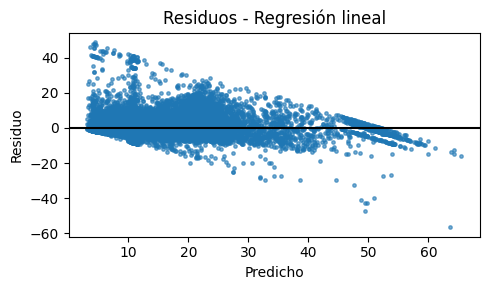

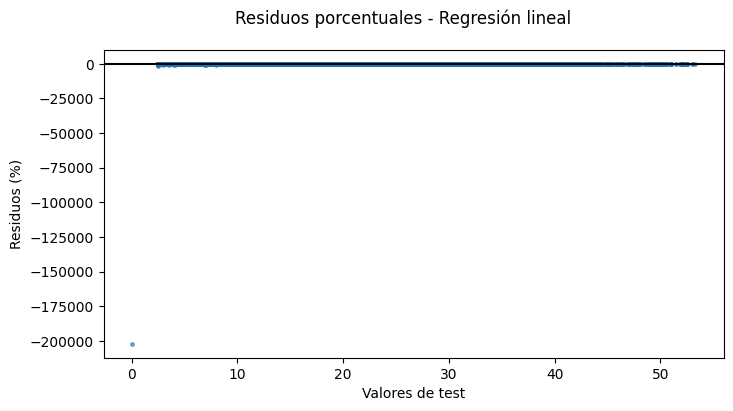

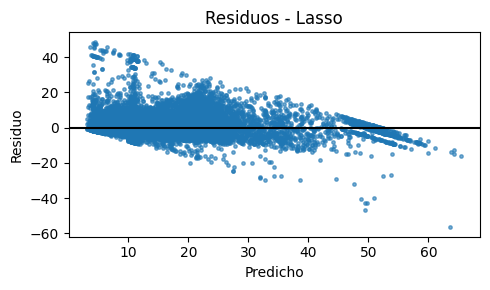

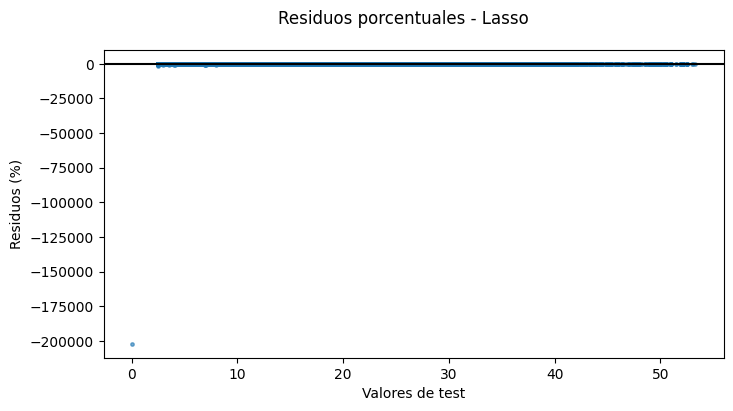

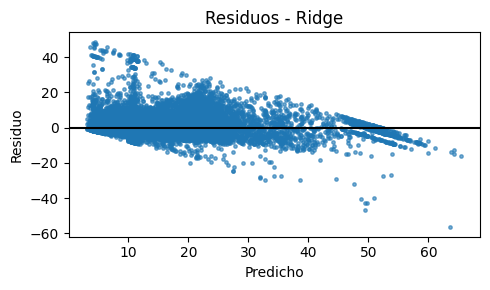

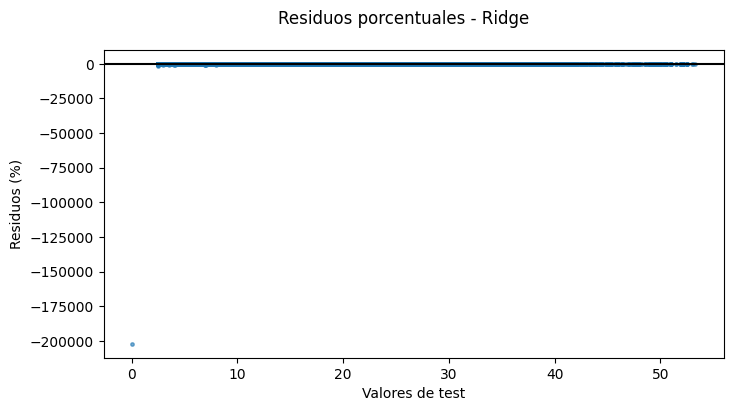

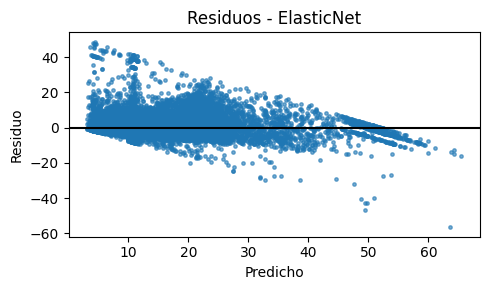

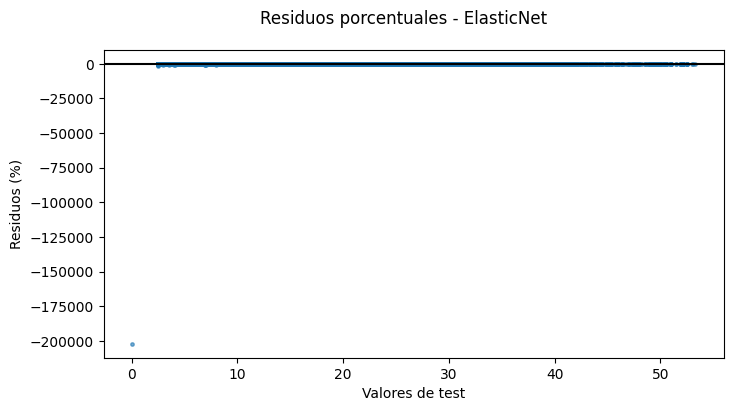

In [229]:
resPlot(linear_model, 'Regresión lineal', x_test, y_test)
resPlot(lasso, 'Lasso', x_test, y_test)
resPlot(ridge, 'Ridge', x_test, y_test)
resPlot(elasticnet, 'ElasticNet', x_test, y_test)


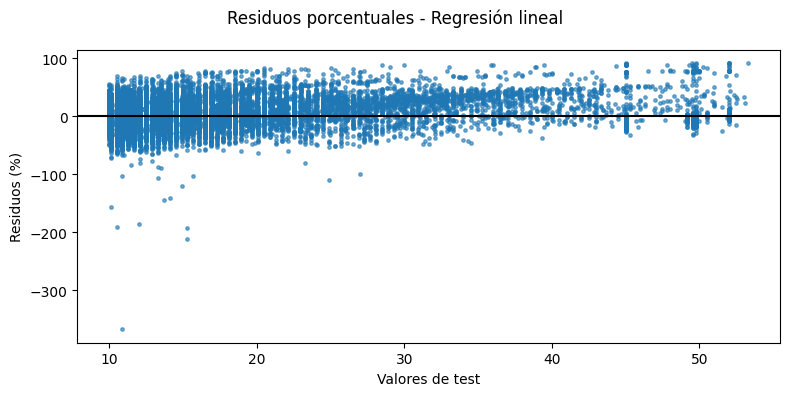

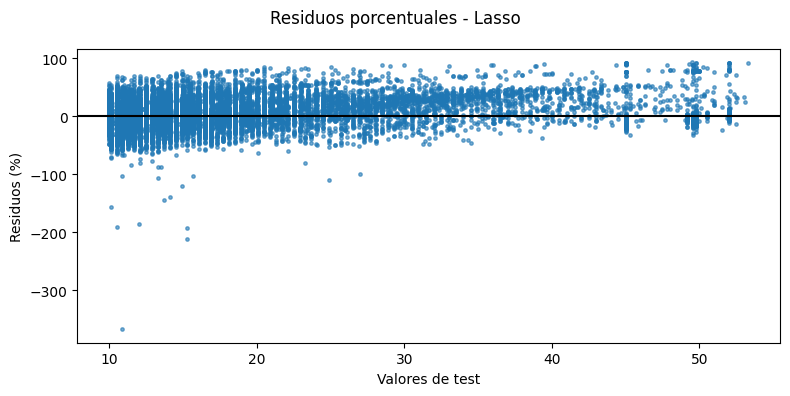

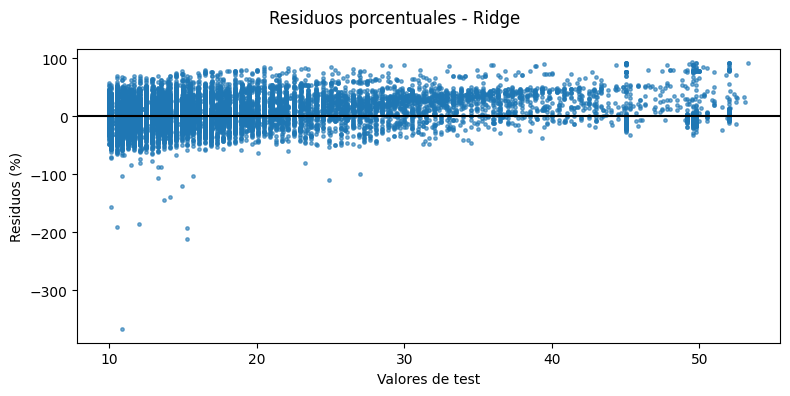

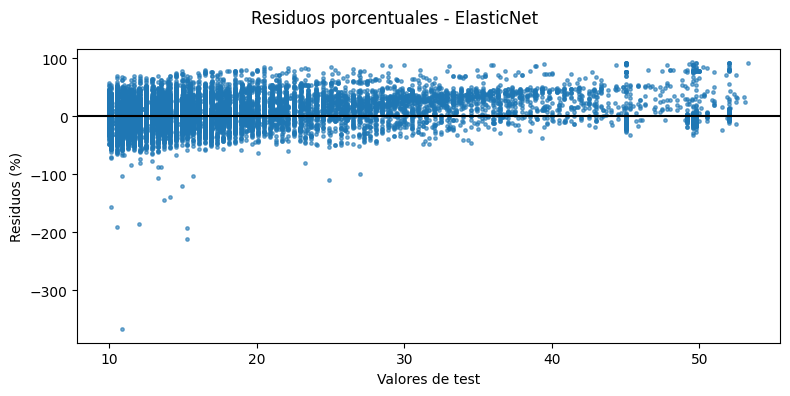

In [230]:
def resPlotAux(modelo, nombre_modelo, x_test, y_test, umbral=10):
    pred = modelo.predict(x_test)
    
    if hasattr(y_test, 'values'):
        y_test_array = y_test.values.ravel()
    else:
        y_test_array = y_test.ravel()
    
    pred = pred.ravel()
    
    # Filtrar valores pequeños de y_test
    mask = np.abs(y_test_array) >= umbral
    y_test_filtrado = y_test_array[mask]
    pred_filtrado = pred[mask]
    
    # Calcular residuos porcentuales
    percentage_residuals = 100 * (y_test_filtrado - pred_filtrado) / y_test_filtrado
    
    # Graficar solo error porcentual
    fig = plt.figure(figsize=(8,4))
    fig.suptitle(f'Residuos porcentuales - {nombre_modelo}')
    plt.xlabel('Valores de test')
    plt.ylabel('Residuos (%)')
    plt.scatter(y_test_filtrado, percentage_residuals, s=6, alpha=0.6)
    plt.axhline(0, color='k')
    plt.tight_layout()
    plt.show()
    
    return

resPlotAux(linear_model, 'Regresión lineal', x_test, y_test)
resPlotAux(lasso, 'Lasso', x_test, y_test)
resPlotAux(ridge, 'Ridge', x_test, y_test)
resPlotAux(elasticnet, 'ElasticNet', x_test, y_test)


# Conclusiones

## Desempeño del modelo
El modelo de regresión lineal alcanzó un **R² de 0.73** (73% de la variabilidad explicada), con métricas de error:

- RMSE: 4.22 USD
- MAE: 2.47 USD
- MAPE: 30%

Los valores de training y test son muy similares, indicando que el modelo generaliza adecuadamente sin overfitting aparente.

## Limitaciones y trabajo futuro
Si bien los resultados son aceptables, identificamos áreas de mejora:

1. **Imputación de coordenadas:** La imputación con KNN podría refinarse

2. **Descenso por gradiente:** La implementación manual presentó problemas de convergencia que serán revisados en la próxima entrega

3. **Regularización:** Los resultados confirman que el modelo no presenta overfitting, por lo que la regularización no es necesaria en este caso

## Análisis de residuos

**Gráfica de residuos vs valores predichos:**

Los residuos se distribuyen de forma aproximadamente aleatoria alrededor de cero, lo cual indica que:
- El modelo de regresión lineal es **apropiado** para este problema
- No se observan patrones sistemáticos evidentes

Sin embargo, se observa que la dispersión de los residuos **aumenta** para valores predichos más altos. Esto significa que:
- El modelo es **más preciso** para viajes económicos ($5-$10)
- El modelo es **menos preciso** para viajes caros ($15-$30)
Aún siendo el modelo más preciso para viajes económicos, el valor del MAE implica que tengo puedo tener un error porcentual alto para precios bajos.

Con esto en mente, sería adecuado tratar el problema con modelos no lineales.